In [1]:
"""
This program is for analysis of
muon decays events
"""
import sys
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import iminuit
import probfit
import uproot
from tqdm.notebook import tqdm, tnrange
# from pkgs.fit.fit import sigmoid
from scipy import integrate
import ROOT
from ROOT import TH1F, TCanvas, TF1
%matplotlib inline

Welcome to JupyROOT 6.18/04


In [2]:
expo = """
double expon(double *x, double *par)
{
return par[0] * TMath::Exp(-1.0 * x[0]/ par[1]);
};
"""
ROOT.gInterpreter.Declare(expo)

True

In [3]:
# We want to speed things up with Cython
%load_ext Cython

In [4]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def sigmoid(double x, double p0, double p1, double p2, double p3):
    return p0 / (1.0 + exp(-1.0 * p2 * (x - p1) ) ) + p3

In [5]:
def analysis(raw_data):
    debug = False
    n_events = raw_data.size
    n_per_event = raw_data[0].size
    timesteps = np.arange(0, n_per_event, 1)
    raw_data = np.negative(raw_data)
    maxs = []
    for m in(raw_data):
        maxs.append(np.max(m))

    risetimes = []
    t1s = []
    t2s = []
    evt = []
    integrals = []
    raw_integrals = []
    print(f'Total number of events: {n_events}')

    for i in tnrange(n_events):
        # smoothed_data = smooth(raw_data[i], window_len=51, window='bartlett')
        smoothed_data = signal.savgol_filter(raw_data[i], 51, 3)
        data = np.concatenate((timesteps[:, np.newaxis],
                               smoothed_data[:n_per_event, np.newaxis]), axis=1)
        peak_range = [0.2, data[:, 1].max()]  # cut for two peaks
        peaks, properties = signal.find_peaks(data[:, 1],
                                              height=peak_range, distance=300)
        results_w = signal.peak_widths(data[:, 1], peaks, rel_height=0.95)
        try:
            i1_raw =  integrate.simps(raw_data[i][int(results_w[2][0]):peaks[0]],
                                      timesteps[int(results_w[2][0]):peaks[0]])
            i2_raw =  integrate.simps(raw_data[i][int(results_w[2][1]):peaks[1]],
                                      timesteps[int(results_w[2][1]):peaks[1]])
            raw_integrals.append([i1_raw, i2_raw])
        except Exception as e:
#                 print(str(e))
            pass

        # and data[peaks[0], 1] > data[peaks[1], 1]
        if len(peaks) >= 2  and data[:, 1].max() < np.max(maxs)-0.01 and peaks[1] < 9000:
            peaks_start = [int(p) for p in (results_w[2])]
            ranged_sm_p1 = data[peaks_start[0]:peaks[0]]
            ranged_sm_p2 = data[peaks_start[1]:peaks[1]]
            temp_times = []
            """
            Calculating Integrals
            """
            i1 = integrate.simps(ranged_sm_p1[:, 1], ranged_sm_p1[:, 0])
            i2 = integrate.simps(ranged_sm_p2[:, 1], ranged_sm_p2[:, 0])
            
            
            integrals.append([i1, i2])
            
            """
            Fitting first peak:
            """
            t1 = np.arange(0, ranged_sm_p1[:, 0].size)
            chi2_fit = probfit.Chi2Regression(
                sigmoid,
                # t1,
                ranged_sm_p1[:, 0],
                ranged_sm_p1[:, 1],
            )

            minuit = iminuit.Minuit(
                chi2_fit,
                p0=np.max(ranged_sm_p1[:, 1]),
                p1=np.mean(ranged_sm_p1[:, 0]),
                # p1=peaks[0],
                # p1=t1.max(),
                p3=np.min(ranged_sm_p1[:, 1]),
                #limit_p3=(np.min(data[a : peaks[0], 1]), None),
                pedantic=False,
                print_level=-1,
            )
            minuit.migrad()
            try:
                minuit.hesse()
            except Exception as e:
#                 print(str(e))
                pass
            p = minuit.values
            tz1 = p[1] - np.log(p[0] / (0.2 * ranged_sm_p1[:, 1].max() - p[3]) - 1.0) / p[2]
            temp_times.append(tz1)
            """
            Fitting second peak
            """
            t2 = np.arange(0, ranged_sm_p2[:, 0].size)
            chi2_fit_p2 = probfit.Chi2Regression(
                sigmoid,
                # t2,
                ranged_sm_p2[:, 0],
                ranged_sm_p2[:, 1],
            )
            
            minuit_p2 = iminuit.Minuit(
                chi2_fit_p2,
                #                 p0=np.max(data[b : peaks[1], 1]),
                p1=np.mean(ranged_sm_p2[:, 0]),
                # limit_p1=(t2.max()/2, t2.max()),
                p3=np.min(ranged_sm_p2[:, 1]),
                #                 limit_p3=(np.min(data[b : peaks[1], 1]), None),
                #                 fix_p3=np.min(data[b : peaks[1], 1]),
                pedantic=False,
                print_level=-1,
            )
            
            minuit_p2.migrad()
            try:
                minuit_p2.hesse()
            except Exception as e:
                print(str(e))
                
            pp = minuit_p2.values
            tz2 = pp[1] - np.log(pp[0] / (0.2 * ranged_sm_p2[:, 1].max() - pp[3]) - 1.0) / pp[2]
            temp_times.append(tz2)
            risetimes.append([temp_times[0], temp_times[1]])
            evt.append(i)
            t1s.append(temp_times[0])
            t2s.append(temp_times[1])

            if debug == True:
                print(f'The value of the variable p0 is {minuit.values["p0"]}')
                print(f'The value of the variable p1 is {minuit.values["p1"]}')
                print(f'The value of the variable p2 is {minuit.values["p2"]}')
                print(f'The value of the variable p3 is {minuit.values["p3"]}')
                print(tz1, tz2)
                print(risetimes)
                plt.figure(figsize=(25, 7))
                chi2_fit_p2.draw(minuit_p2)
                plt.show()

    return (evt, t1s, t2s, integrals, raw_integrals)


In [6]:
files = ["oscil_191216.root", "mudecays824.root", "muon_191218/" + "oscill_191218.root"]
f_name = files[1]
rel_path = "../../Labs/muon_decay/"
filename = rel_path + f_name

In [7]:
# ev = []
# t1_tot = []
# t2_tot = []
# ints = []
# raw_ints = []
# tree_names = ["t1", "tree"]
# for file in files:
#     f_name = rel_path + file
    
#     for t_n in tree_names:
#         try:
#             df_np = uproot.open(f_name)[t_n].array("channel1")
#             break
#         except Exception as ex:
#             print(ex)
#     evv, tz1, tz2, ints_p, raw_ints_p = analysis(df_np)
#     print(f'Found {len(evv)} number of events in file {file}')
#     ev.extend(evv)
#     t1_tot.extend(tz1)
#     t2_tot.extend(tz2)
#     ints.extend(ints_p)
#     raw_ints.extend(raw_ints_p)
    

# tz1 = np.asarray(t1_tot)
# tz2 = np.asarray(t2_tot)
# times = np.concatenate((tz1[:, np.newaxis], tz2[:, np.newaxis]), axis=1)
# # np.savetxt(f'{filename[:-5]}_events.log', ev, fmt='%1i')

# diffs = tz2 - tz1
# t_step_per_point = 4 * 1e-04 # in μs
# diffs *= t_step_per_point

In [8]:
tree_names = ["t1", "tree"]
for t_n in tree_names:
    try:
        df_np = uproot.open(filename)[t_n].array("channel1")
        break
    except Exception as ex:
        print(ex)

ev, tz1, tz2, ints, raw_ints = analysis(df_np)
tz1 = np.asarray(tz1)
tz2 = np.asarray(tz2)
times = np.concatenate((tz1[:, np.newaxis], tz2[:, np.newaxis]), axis=1)
np.savetxt(f'{filename[:-5]}_events.log', ev, fmt='%1i')

diffs = tz2 - tz1
t_step_per_point = 4 * 1e-04 # in μs
diffs *= t_step_per_point

Total number of events: 824


In [9]:
print(f'Found {len(ev)} events')
# print(ev)

Found 367 events


In [10]:
npints = np.asarray(ints)

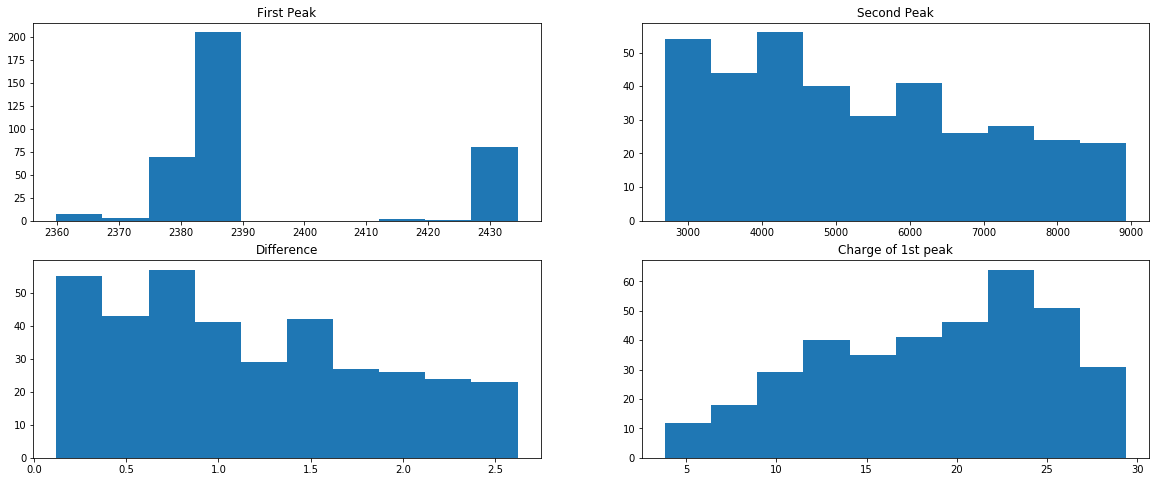

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(221)
plt.hist(times[:, 0])
plt.title("First Peak")
plt.subplot(222)
plt.hist(times[:, 1])
plt.title("Second Peak")
plt.subplot(223)
plt.hist(diffs)
plt.title("Difference")
plt.subplot(224)
plt.hist(npints[:,0])
plt.title("Charge of 1st peak")
plt.show()

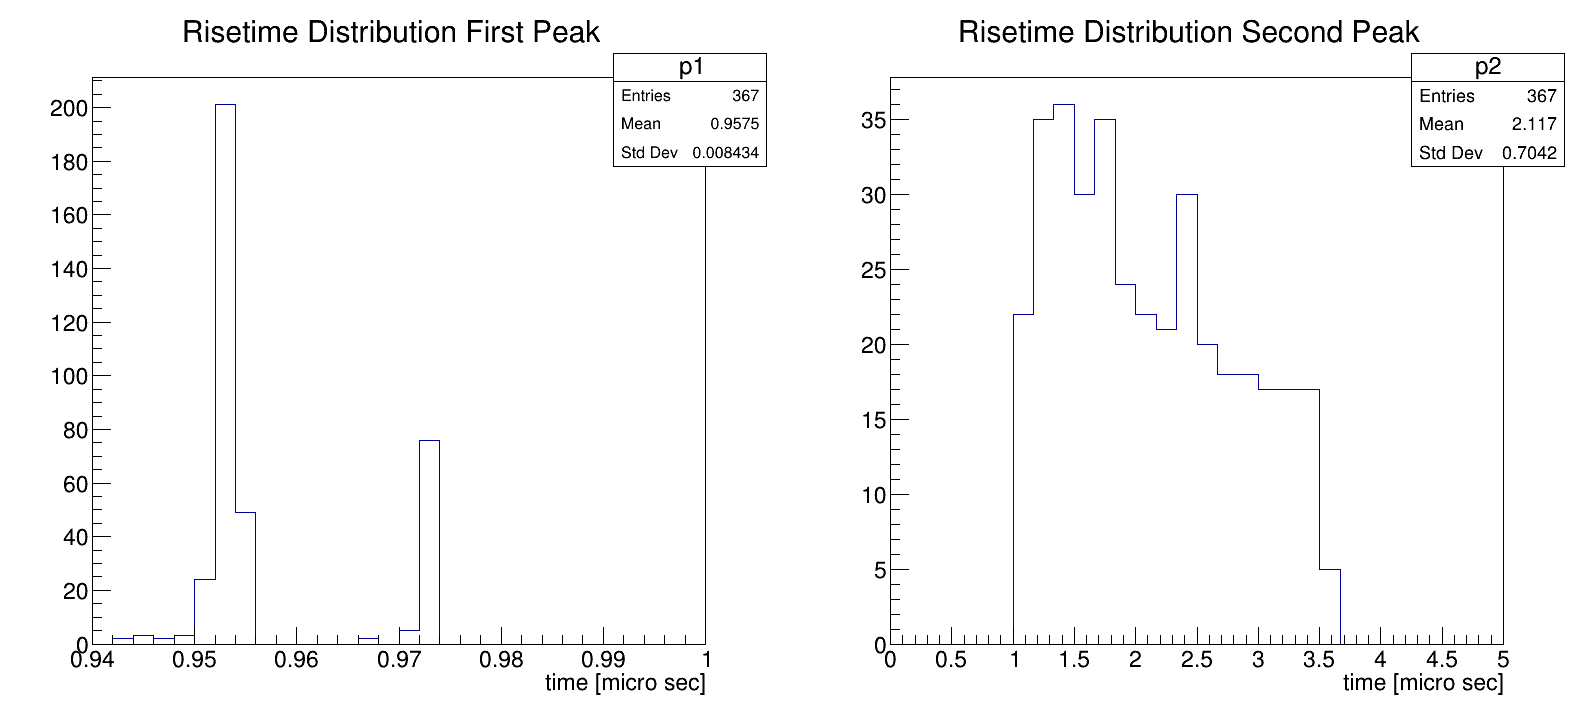

In [12]:
# fit_exp = TF1("fit_exp", ROOT.expon, diffs.min(), diffs.max(), 2)
# fit_exp = TF1("fit_exp", ROOT.expon, 500, 2000, 2)
fit_exp = TF1("fit_exp", "expo", diffs.min(), diffs.max(), 2)
fit_exp.SetParameter(0, 6)
fit_exp.SetParameter(1, 1e-03)
c1 = TCanvas("Histograms", "test", 1600,750)
c1.Divide(2)
p1 = TH1F("p1", "Risetime Distribution First Peak", 30, 0.94, 1)
p2 = TH1F("p2", "Risetime Distribution Second Peak", 30, 0, 5)
diff = TH1F("diff", "Difference of risetimes", 100, 0, diffs.max())
for i in range(tz1.size):
    p1.Fill(tz1[i]*t_step_per_point)
    p2.Fill(tz2[i]*t_step_per_point)
    diff.Fill(diffs[i])
c1.cd(1)
p1.Draw()
p1.GetXaxis().SetTitle("time [micro sec]")
c1.cd(2)
p2.Draw()
p2.GetXaxis().SetTitle("time [micro sec]")
c1.Draw()
c1.Update()

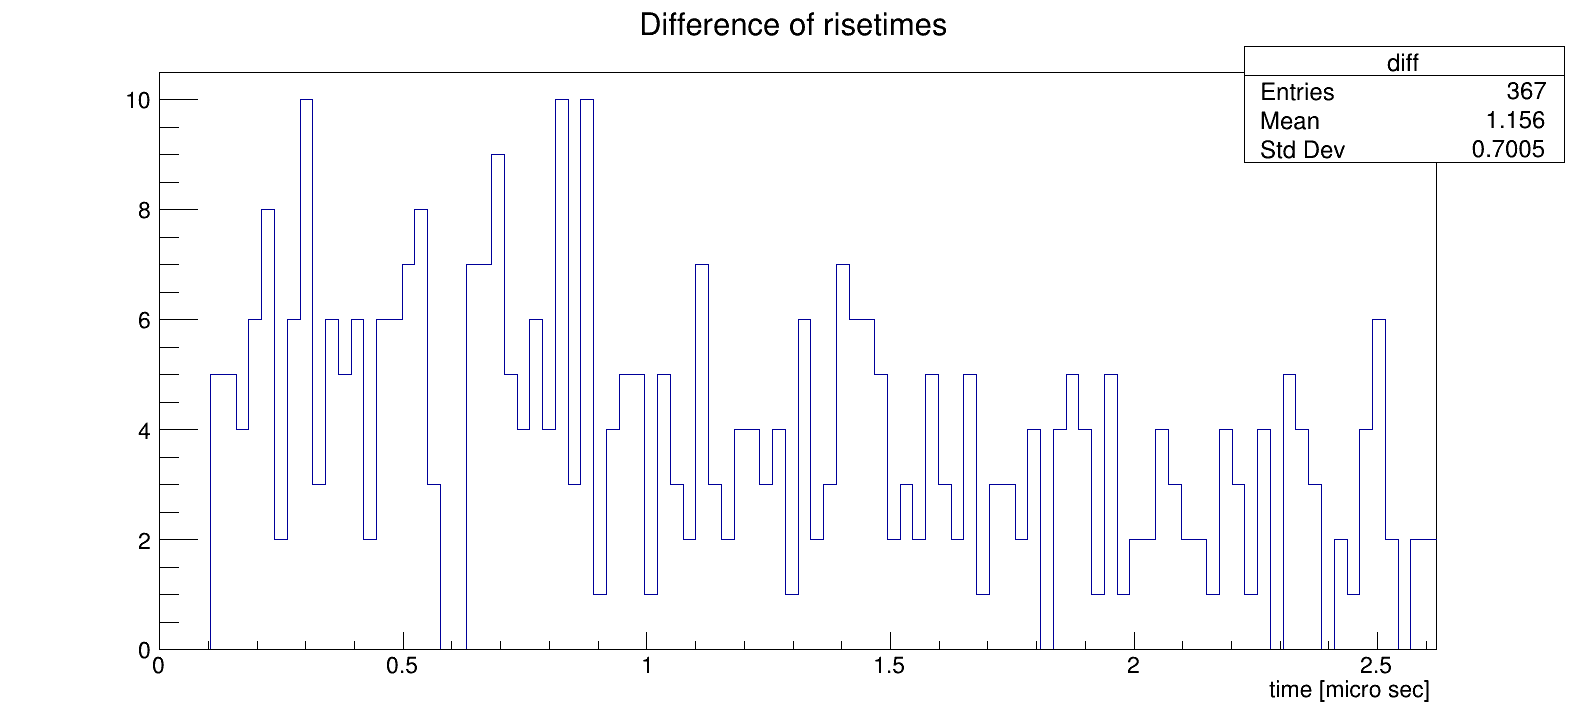

In [13]:
c11 = TCanvas("diffs", "test", 1600,750)
diff.Draw()
# diff.Fit(fit_exp, "R")
diff.GetXaxis().SetTitle("time [micro sec]")
c11.Draw()

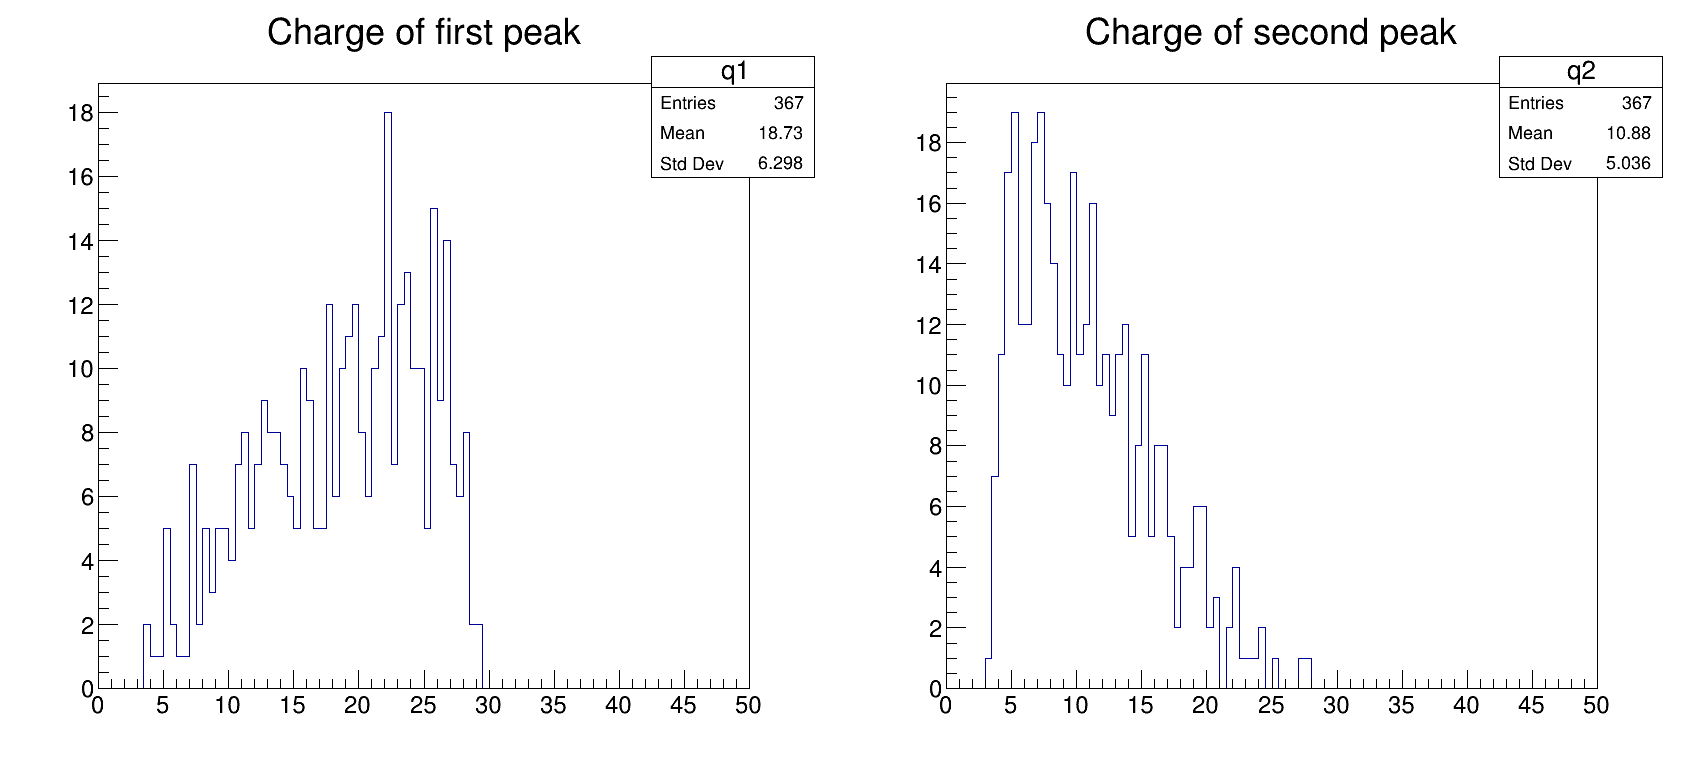

In [14]:
c2 = TCanvas("Charges", "test", 1700,800)
c2.Divide(2)
q1 = TH1F("q1", "Charge of first peak", 100, 0, 50)
q2 = TH1F("q2", "Charge of second peak", 100, 0, 50)
for i in range(len(ev)):
    q1.Fill(ints[i][0])
    q2.Fill(ints[i][1])
c2.cd(1)
q1.Draw()
c2.cd(2)
q2.Draw()
c2.Draw()
c2.Update()

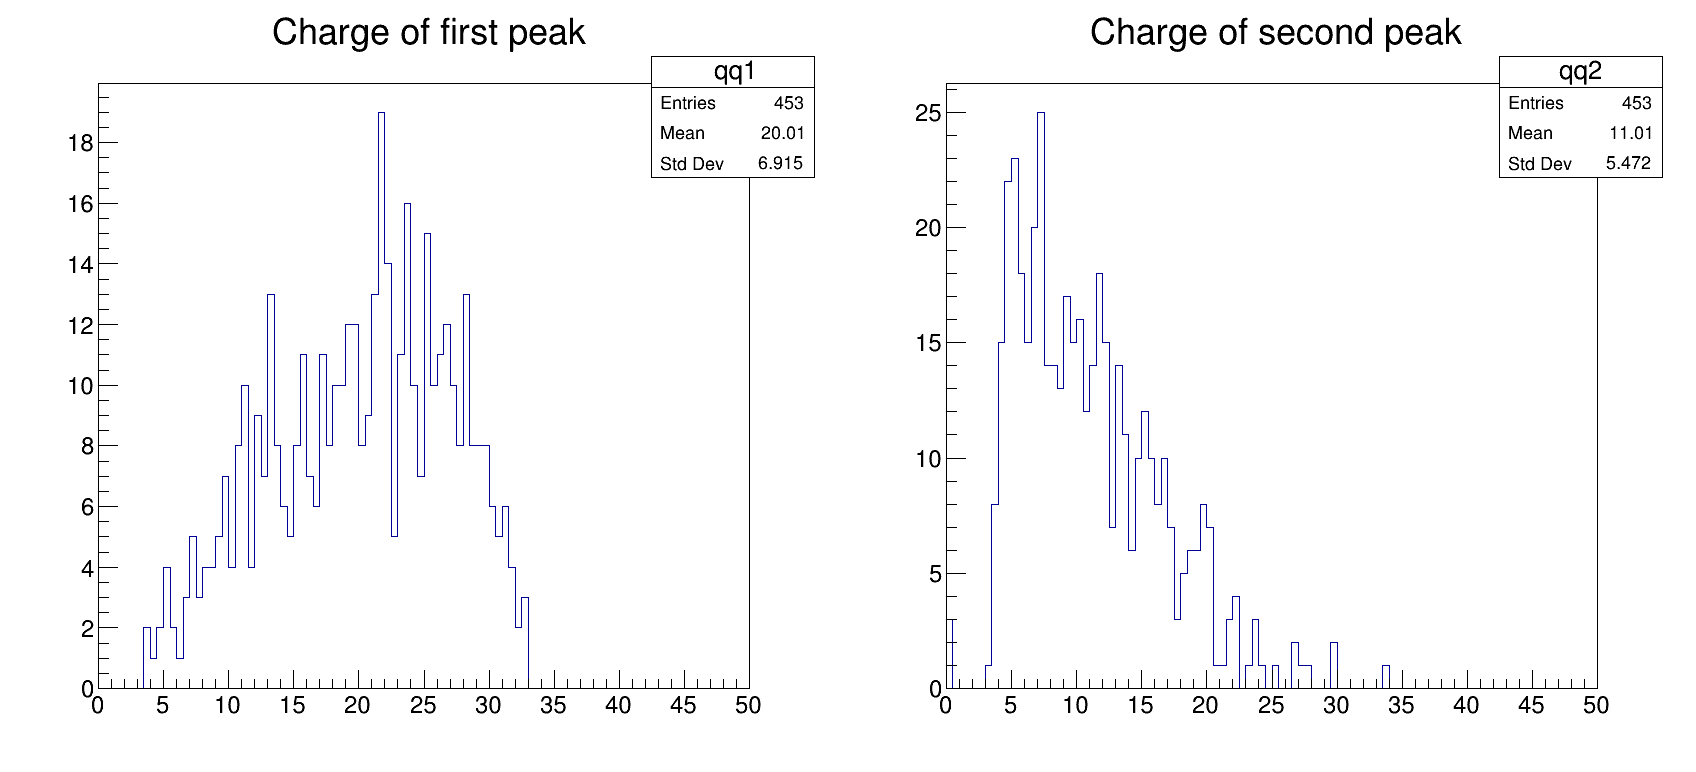

In [15]:
# ROOT.gStyle.SetOptTitle(0);
c3 = TCanvas("c3", "Raw Charges", 1700,800)
# title = ROOT.TPaveLabel(0.7,0.95,0.3,0.9,"ayy");
c3.Divide(2)
qq1 = TH1F("qq1", " Charge of first peak", 100, 0, 50)
qq2 = TH1F("qq2", " Charge of second peak", 100, 0, 50)
for i in range(len(raw_ints)):
    qq1.Fill(raw_ints[i][0])
    qq2.Fill(raw_ints[i][1])
# title.Draw()
c3.cd(1)
qq1.Draw()
c3.cd(2)
qq2.Draw()
c3.Draw()
c3.Update()



RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(dh): fit range of variable x expanded to nearest bin boundaries: [0.2,2] --> [0.183435,2.01778]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'signal' created with bounds [0.4,2]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_expo_dh) constructing test statistic for sub-range named signal
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'NormalizationRangeForsignal' created with bounds [0.183435,2.01778]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit_nll_expo_dh' created with bounds [0.4,2]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_expo_dh) fixing interpretation of coefficients of any RooAddPdf to full domain of observables 
[#1] IN

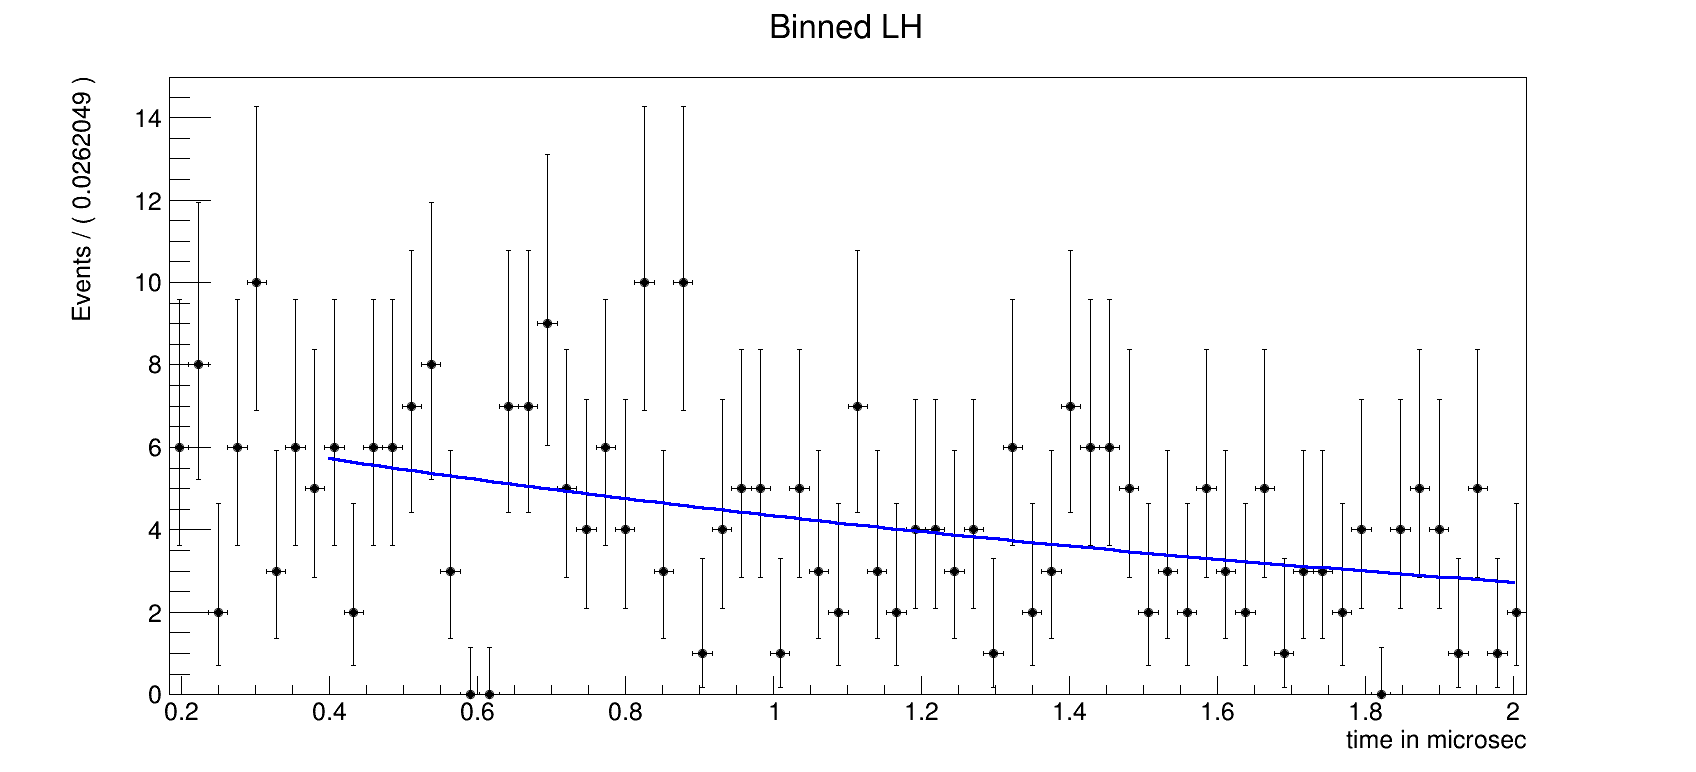

In [16]:
c4 = TCanvas("c4", "Binned LH", 1700,800)

x = ROOT.RooRealVar("x", "time in microsec", 0.2, 2)
slp = ROOT.RooRealVar("slp", "slope", -0.5, -1.0, -0.1)
expo = ROOT.RooExponential("expo", "expo PDF", x, slp)
dh = ROOT.RooDataHist("dh", "data", ROOT.RooArgList(x), diff)

x.setRange("signal", 0.4, 2)
result = expo.fitTo(dh, ROOT.RooFit.PrintLevel(0), ROOT.RooFit.Range("signal"))

slp.Print()

xframe = x.frame(ROOT.RooFit.Title("Binned LH"))
dh.plotOn(xframe, ROOT.RooLinkedList())
expo.plotOn(xframe)
xframe.Draw()
diff.DrawClone("SAME")
c4.Draw()

In [17]:
print(f'lifetime is {-1/slp.getVal()} +- {slp.getError()} us')

lifetime is 2.165218444853659 +- 0.1373039430246556 us


# Unbinned LH with RooFit

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
 **********
 **   10 **SET PRINT           0
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 slp_un      -4.00000e-01  4.00000e-02   -5.00000e-01 -1.00000e-01
 **********
 **   12 **SET ERR         0.5
 **********
 **********
 **   13 **SET PRINT           0
 **********
 **********
 **   14 **SET STR           1
 **********
 **********
 **   15 **MIGRAD         500           1
 **********
 MIGRAD MINIMIZATION HAS CONVERGED.
 MIGRAD WILL VERIFY CONVERGENCE AND ERROR MATRIX.
 FCN=320.112 FROM MIGRAD    STATUS=CONVERGED      18 CALLS          19 TOTAL
                     EDM=2.57355e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  slp_un      -4.13651e-01   7.18093e

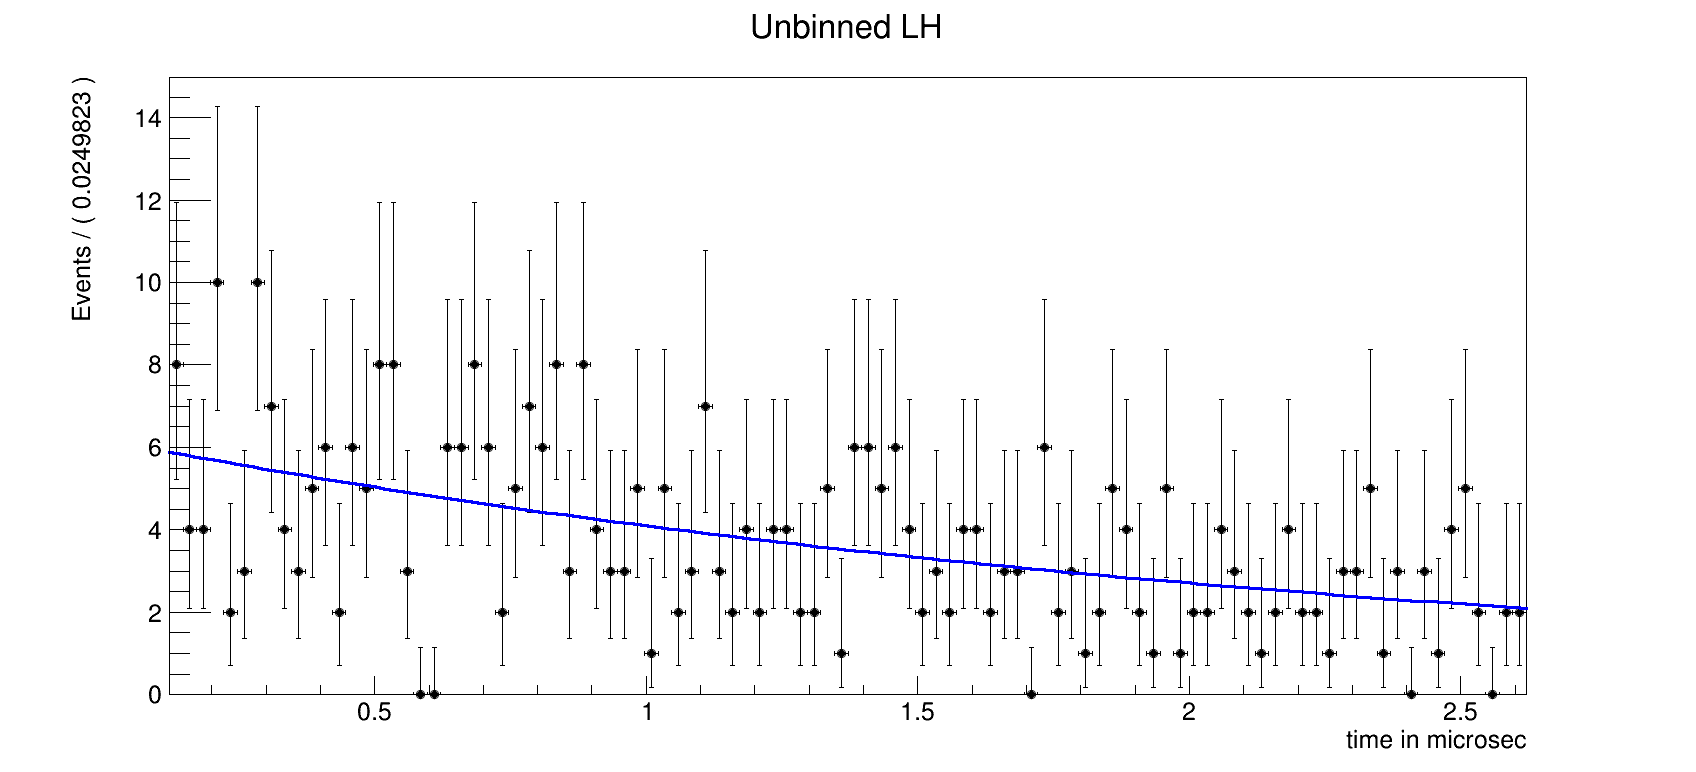

In [18]:
c5 = TCanvas("c5", "Unbinned LH", 1700,800)

x_un = ROOT.RooRealVar("x_un", "time in microsec",diffs.min(), diffs.max())
data_un = ROOT.RooDataSet("data_un", "Unbinned ML", ROOT.RooArgSet(x_un))

for d in diffs:
    x_un.setVal(d)
    data_un.add(ROOT.RooArgSet(x_un))
slp_un = ROOT.RooRealVar("slp_un", "slope", -0.4, -0.5, -0.1)
expo_un = ROOT.RooExponential("expo_un", "expo PDF", x_un, slp_un)
# x_un.setRange("signal", 0.4, 2)
result_un = expo_un.fitTo(data_un, ROOT.RooFit.PrintLevel(0)) #, ROOT.RooFit.Range("signal"))

slp_un.Print()

xframe = x_un.frame(ROOT.RooFit.Title("Unbinned LH"))
data_un.plotOn(xframe, ROOT.RooLinkedList())
expo_un.plotOn(xframe)
xframe.Draw()
c5.Draw()

In [19]:
slp_un.Print()
t_r = -1/slp_un.getVal()
t_err = slp_un.getError()/(t_r * t_r)
print(f'lifetime is {t_r} +- {t_err} us')


lifetime is 2.417495908937117 +- 0.0122870587109027 us
RooRealVar::slp_un = -0.413651 +/- 0.0718091  L(-0.5 - -0.1) 


In [20]:
%%cython
cimport cython
from libc.math cimport exp
@cython.binding(True) # IMPORTANT: this tells Cython to dump the function signature
def expon_cy(double x, double p1):
    return  exp(1.0 * p1 * x)

# Binned Likelihood with probfit

In [21]:
fit_range = (0.4, 2)
bLH_fit = probfit.BinnedLH(expon_cy, diffs, bins=50, bound=fit_range)

minuit_bLH = iminuit.Minuit(
    bLH_fit,
#     p0=0.5,
    p1=-3e-03,
#     limit_p0=(1, None),
#     limit_p1=(-4e-03, -0.001),
    pedantic=True,
    print_level=1,
)
minuit_bLH.migrad()
try:
    minuit_bLH.hesse()
except Exception as e:
    print(str(e))

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: InitialParamWarning: Parameter p1 is floating but does not have initial step size. Assume 1.
  # This is added back by InteractiveShellApp.init_path()
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: LogWarning: x is really small return 0
  del sys.path[0]


------------------------------------------------------------------
| FCN = 26.22                   |      Ncalls=19 (19 total)      |
| EDM = 1.44E-06 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: LogWarning: x is really small return 0
  from ipykernel import kernelapp as app


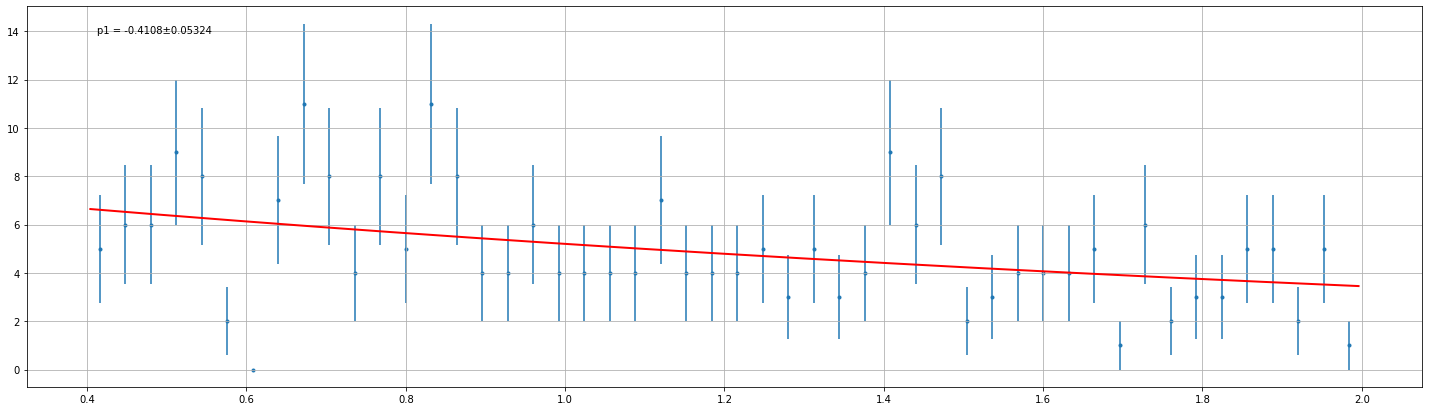

In [22]:
plt.figure(figsize=(25, 7))
bLH_fit.draw(minuit_bLH)
plt.show()

In [23]:
-1/minuit_bLH.values[0]

2.4343224515722675

# Unbinned likelihood with probfit (not working yet)

------------------------------------------------------------------
| FCN = 85.14                   |      Ncalls=13 (13 total)      |
| EDM = 1.39E-16 (Goal: 5E-06)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
--------------

/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: InitialParamWarning: Parameter p1 does not have initial value. Assume 0.
  # Remove the CWD from sys.path while we load stuff.
/home/john/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: InitialParamWarning: Parameter p1 is floating but does not have initial step size. Assume 1.
  # Remove the CWD from sys.path while we load stuff.


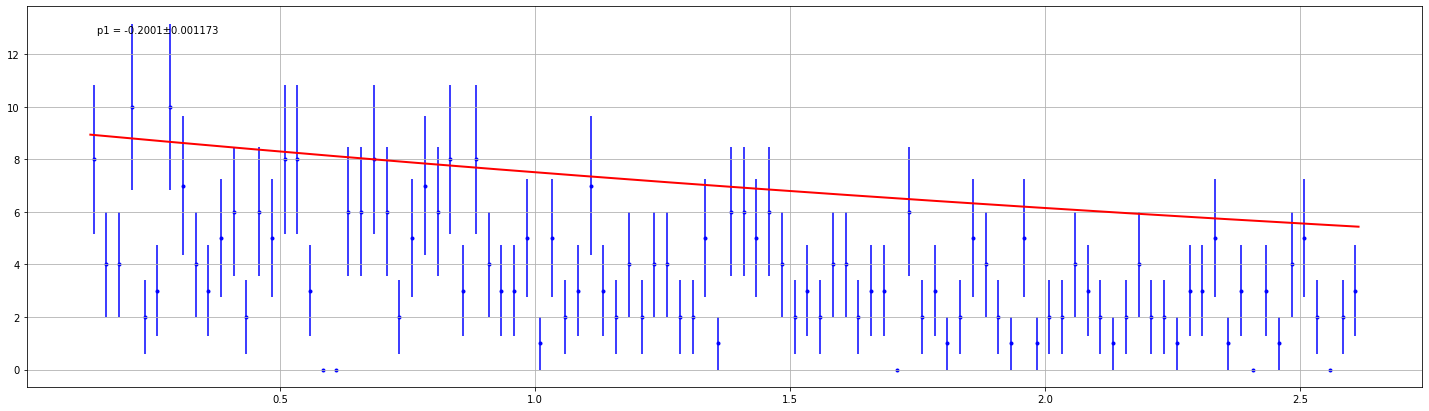

In [24]:
unbLH_fit = probfit.UnbinnedLH(expon_cy, diffs)

minuit_LH = iminuit.Minuit(
    unbLH_fit,
#     p0=0.5,
#     p1=-3e-03,
#     limit_p0=(0.1, 1.2),
    limit_p1=(-0.5, -0.2),
    pedantic=True,
    print_level=1,
)
minuit_LH.migrad()
try:
    minuit_LH.hesse()
except Exception as e:
    print(str(e))
    
plt.figure(figsize=(25, 7))
unbLH_fit.draw(minuit_LH)
plt.show()

In [25]:
c1.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_trs.png")
c11.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_trdiffs.png")
c2.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_rawQ2.png")
# c3.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_rawQ.png")
c4.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_bnLH.png")
c5.SaveAs(f"/home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/{f_name[:-5]}_unLH.png")

Info in <TCanvas::Print>: png file /home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/mudecays824_trs.png has been created
Info in <TCanvas::Print>: png file /home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/mudecays824_trdiffs.png has been created
Info in <TCanvas::Print>: png file /home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/mudecays824_rawQ2.png has been created
Info in <TCanvas::Print>: png file /home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/mudecays824_bnLH.png has been created
Info in <TCanvas::Print>: png file /home/john/Documents/SubAtomics/Semester3/Detectors/Reports/figs/plots/muons/mudecays824_unLH.png has been created


In [26]:
f_name[12:-5]

''